In [94]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.offsetbox import AnchoredText
import scipy.optimize
import pandas as pd
from IPython.display import clear_output
from time import sleep



# Exercise 7: Wolff Algorithm
This time, instead of a Metropolis ALgorithm with local spin flips, the WOlff Algorithm was implemented.
in this algorithm, a random spin of the system is chosen as a cluster center.Its nearest neighbours are added to the cluster if they share the spin of the center cluster with a probability 
$$P_{add} = 1- exp(-2 \beta J)$$ 

Then the whole cluster is flipped with probability 1. In my implementation, I flipp each cluster as it joins to prevent the algorithm to revisit neighbours  that have already joined the cluster. Neighbours that have not joined the cluster can still be revisited for a join attempt through other neighbours though.

Below is a little animation of the simulation at low temperatures.


In [105]:
#read in the data from csv file
data = []
with open('exercise7_sim_animation.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    next(contents)#skip header line
    for row in contents:
        array= np.asarray(row).astype('int')
        data.append(np.reshape(array,(50,50)))


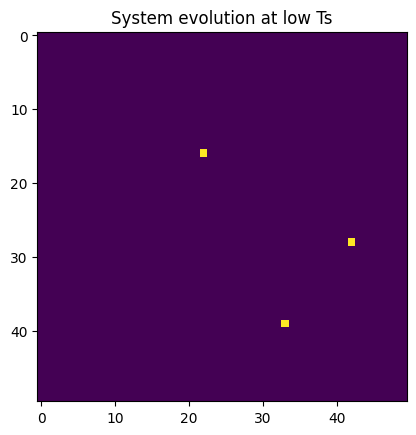

In [96]:

for i in range(40):
    plt.title("System evolution at low Ts")
    plt.imshow(data[i])
    plt.show()

    sleep(0.001)
    clear_output(wait=True)

## Cluster Size Statistics

The Probability to add a neighbour to the cluster, $P_{add}$ depends on the temperature through $\beta = \frac{1}{k_b T}$ . At very high temperatures beta becomes very small and thus $P_{add} \approx 0$, so it can be expected to find ecffectively moslty single spin flips and small clusters. For low temperatures, or large $\beta$, $P_{add} \approx 1$, so clusters can become so large that the whole system is joined. This can actually be seen in the above simulation, with the whole system flipping together.

This is further investigated below. The Ising model was simulated with the Wolff Algorithm at 3 different Temperatures:
$$T_l = 0.5 T_c, T_c= , T_h = 2 T_c$$
The cluster sizes during the Simulation were recorded and are plotted in Histogramms below


In [107]:
#read in the data from csv file
data = []
with open('exercise7_other.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    #next(contents)#skip header line
    for row in contents:
        array= np.asarray(row).astype('float')
        data.append(array)
Tc=2/np.log(1+np.sqrt(2))
Temperatures=[0.5*Tc, Tc,Tc*2]

clustersizes=data[:3]
Magnetisations_Wolff= data[4:15:2]
clustersizes_corr=data[3:15:2]
Magnetisations_Metropolis= data[15:]
print(data[5])
print(len(Magnetisations_Metropolis))

[4.000e+00 8.000e+00 2.000e+00 ... 5.000e+00 2.907e+03 3.153e+03]
6


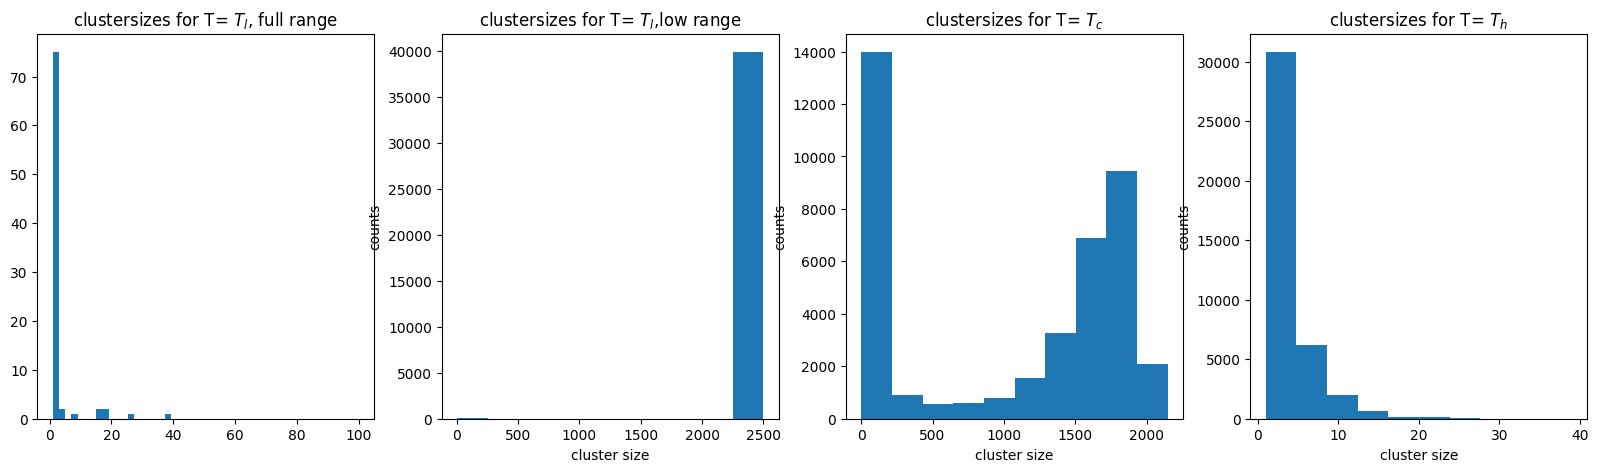

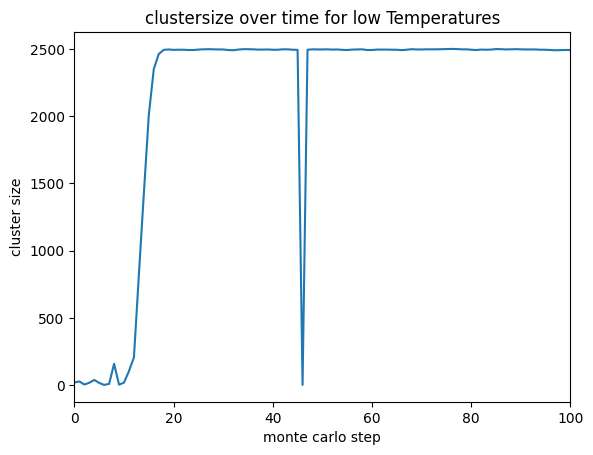

In [98]:
fig, axs= plt.subplots(1,4, figsize=(20,5))
titles=["clustersizes for T= $T_l$, full range","clustersizes for T= $T_l$,low range","clustersizes for T= $T_c$","clustersizes for T= $T_h$"]
axs[0].set_title(titles[0])
axs[0].hist(clustersizes[0],bins= np.linspace(1,100))
for i in range(1,4):
    axs[i].set_title(titles[i])
    axs[i].set_ylabel("counts")
    axs[i].set_xlabel("cluster size")
    axs[i].hist(clustersizes[i-1])
fig,ax = plt.subplots()  
ax.set_title("clustersize over time for low Temperatures") 
ax.set_xlim(0,100)
ax.set_xlabel("monte carlo step")
ax.set_ylabel("cluster size")
ax.plot(clustersizes[0])
plt.show()

One can clearly see the expected behaviour. At low temperatures, almost all clusters involve the whole system. By looking at the lower plot, it becomes quite clear that the few single spin flips and small clsuters seem to appear in the beginning of the simualtion. Close to the critical temperature a big range of cluster sizes appears, and at high temperatures, single spin flips and very small clusters dominate.


## Correlation time
For a range of system sizes, the Ising model was smulated with the Wolff Algorithm and the previously implemented local move Metropolis Algorithm. 

exponents z for L dependency of correlation time: Metropolis z_m = 0.87 ; Wolff z_w = 0.25


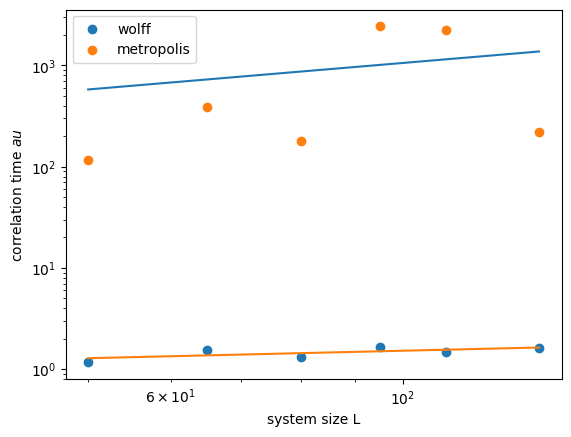

In [111]:
Ls=np.array([50,65,80,95,110,135])

def exp(x,tau,a):
    return a*np.exp(-x/tau)
def powerlaw(x,a,b):
    return(b*x**a)

def calc_autocorrellation(array, lag_max, t_eq):
    array=array[t_eq::]
    array_centered= array-np.average(array)
    N_samples= len(array)
    autocov = np.empty(lag_max)
    lagtimes=np.arange(0,lag_max)
    for j in range(lag_max):
        autocov[j] = np.dot(array_centered[:N_samples - j],array_centered[j:])
    autocov /= (N_samples-lagtimes)
    return autocov
lagmax=100
lagtimes=np.arange(0,lagmax)
k=0
auto_times_wolff=[]
auto_times_metropolis=[]

for i,L in enumerate(Ls):
    autocorr1= calc_autocorrellation(np.abs(Magnetisations_Wolff[i]),lagmax, t_eq=3000)
    popt1,pcov1=scipy.optimize.curve_fit(exp,lagtimes,autocorr1)
    
    auto_times_wolff.append(popt1[0])

    autocorr2=calc_autocorrellation(Magnetisations_Metropolis[i],lagmax, t_eq=3000)
    popt2,pcov2=scipy.optimize.curve_fit(exp,lagtimes,autocorr2)
    auto_times_metropolis.append(popt2[0])
auto_times_metropolis=np.array(auto_times_metropolis)
auto_times_wolff= np.array(auto_times_wolff)*np.mean(clustersizes_corr,axis=1)/np.array(Ls)**2
popt_m,pcov_m= scipy.optimize.curve_fit(powerlaw,Ls,auto_times_metropolis)
popt_w,pcov_w= scipy.optimize.curve_fit(powerlaw,Ls,auto_times_wolff)
print("exponents z for L dependency of correlation time: Metropolis z_m = %.2f ; Wolff z_w = %.2f"%(popt_m[0],popt_w[0]))
plt.xscale("log")
plt.yscale("log")

plt.xlabel("system size L")
plt.ylabel("correlation time $\tau$")
plt.scatter(Ls,auto_times_wolff,label="wolff")
plt.plot(Ls,powerlaw(Ls,*popt_m))
plt.plot(Ls,powerlaw(Ls,*popt_w))
plt.scatter(Ls,auto_times_metropolis,label="metropolis")
plt.legend()
plt.show()

